In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from xgboost import XGBClassifier

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

In [3]:
file_path = '/kaggle/input/hypertension-risk-prediction-dataset/hypertension_dataset.csv' 
df = pd.read_csv(file_path)

In [4]:
df.head()

,Age,Salt_Intake,Stress_Score,BP_History,Sleep_Duration,BMI,Medication,Family_History,Exercise_Level,Smoking_Status,Has_Hypertension
0,69,8.0,9,Normal,6.4,25.8,NaN,Yes,Low,Non-Smoker,Yes
1,32,11.7,10,Normal,5.4,23.4,NaN,No,Low,Non-Smoker,No
2,78,9.5,3,Normal,7.1,18.7,NaN,No,Moderate,Non-Smoker,No
3,38,10.0,10,Hypertension,4.2,22.1,ACE Inhibitor,No,Low,Non-Smoker,Yes
4,41,9.8,1,Prehypertension,5.8,16.2,Other,No,Moderate,Non-Smoker,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1985 non-null   int64  
 1   Salt_Intake       1985 non-null   float64
 2   Stress_Score      1985 non-null   int64  
 3   BP_History        1985 non-null   object 
 4   Sleep_Duration    1985 non-null   float64
 5   BMI               1985 non-null   float64
 6   Medication        1186 non-null   object 
 7   Family_History    1985 non-null   object 
 8   Exercise_Level    1985 non-null   object 
 9   Smoking_Status    1985 non-null   object 
 10  Has_Hypertension  1985 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 170.7+ KB


In [6]:
df.isnull().sum()

Age                   0
Salt_Intake           0
Stress_Score          0
BP_History            0
Sleep_Duration        0
BMI                   0
Medication          799
Family_History        0
Exercise_Level        0
Smoking_Status        0
Has_Hypertension      0
dtype: int64

In [7]:
df['Has_Hypertension'] = df['Has_Hypertension'].map({'Yes': 1, 'No': 0})
df[['Has_Hypertension']].head()

,Has_Hypertension
0,1
1,0
2,0
3,1
4,0


In [8]:
df['Medication'].fillna('None', inplace=True)
df['Medication'].isnull().sum()

0

In [9]:
bp_history_mapping = {'Normal': 0, 'Prehypertension': 1, 'Hypertension': 2}
df['BP_History'] = df['BP_History'].map(bp_history_mapping)
df[['BP_History']].head()

,BP_History
0,0
1,0
2,0
3,2
4,1


In [10]:
categorical_cols_for_onehot = ['Family_History', 'Exercise_Level', 'Smoking_Status', 'Medication']

df = pd.get_dummies(df, columns=categorical_cols_for_onehot, drop_first=True, dtype=int)
df.head()

,Age,Salt_Intake,Stress_Score,BP_History,Sleep_Duration,BMI,Has_Hypertension,Family_History_Yes,Exercise_Level_Low,Exercise_Level_Moderate,Smoking_Status_Smoker,Medication_Beta Blocker,Medication_Diuretic,Medication_None,Medication_Other
0,69,8.0,9,0,6.4,25.8,1,1,1,0,0,0,0,1,0
1,32,11.7,10,0,5.4,23.4,0,0,1,0,0,0,0,1,0
2,78,9.5,3,0,7.1,18.7,0,0,0,1,0,0,0,1,0
3,38,10.0,10,2,4.2,22.1,1,0,1,0,0,0,0,0,0
4,41,9.8,1,1,5.8,16.2,0,0,0,1,0,0,0,0,1


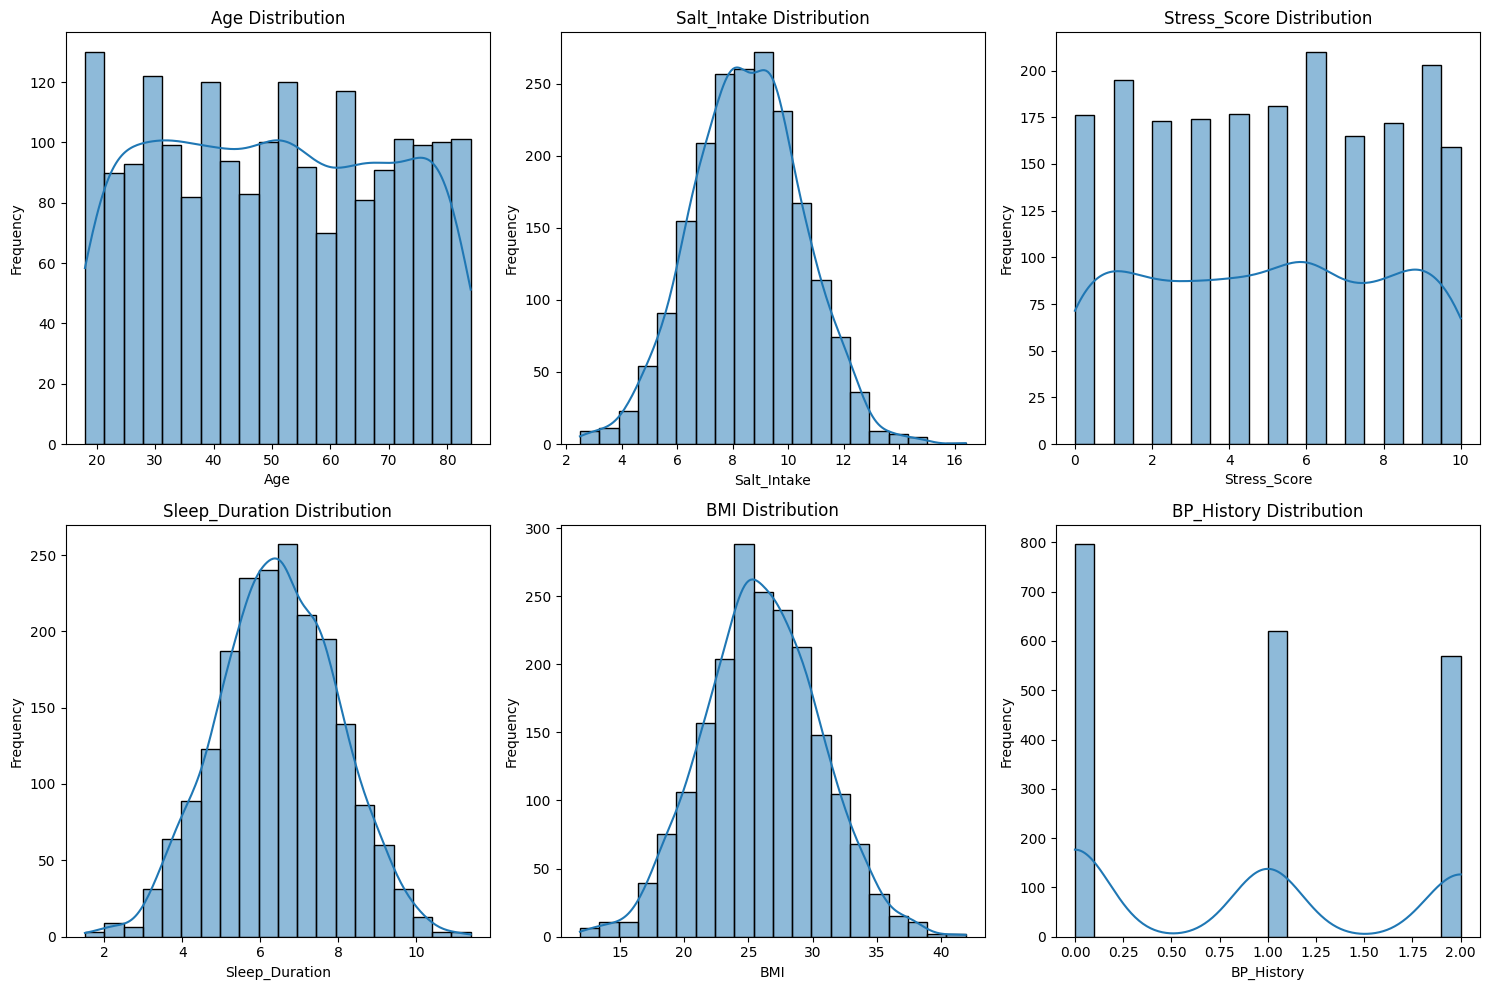

In [11]:
numeric_cols = ['Age', 'Salt_Intake', 'Stress_Score', 'Sleep_Duration', 'BMI', 'BP_History']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1) 
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

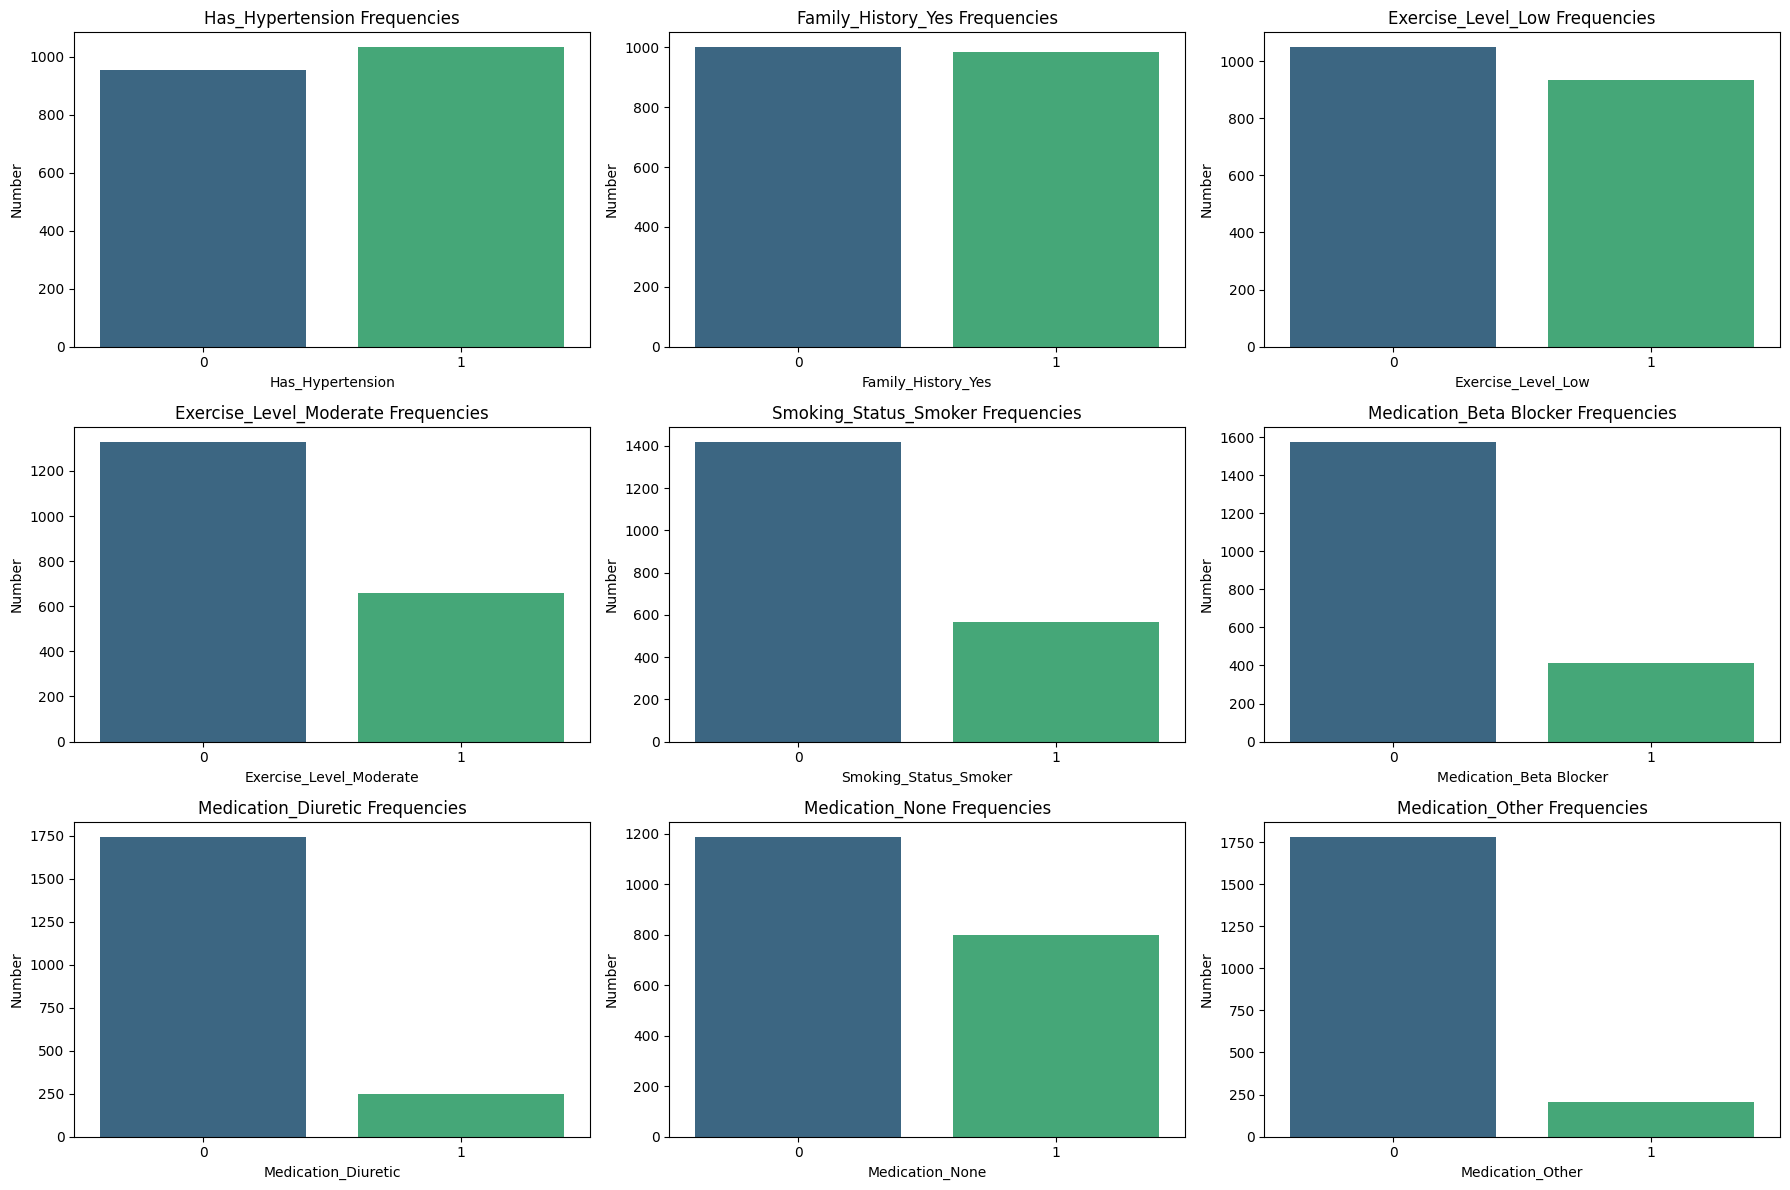

In [12]:
categorical_encoded_cols = ['Has_Hypertension', 'Family_History_Yes', 'Exercise_Level_Low',
                            'Exercise_Level_Moderate', 'Smoking_Status_Smoker',
                            'Medication_Beta Blocker', 'Medication_Diuretic',
                            'Medication_None', 'Medication_Other']

plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_encoded_cols):
    plt.subplot(3, 3, i + 1) 
    sns.countplot(x=df[col], palette='viridis')
    plt.title(f'{col} Frequencies')
    plt.xlabel(col)
    plt.ylabel('Number')
plt.tight_layout()
plt.show()

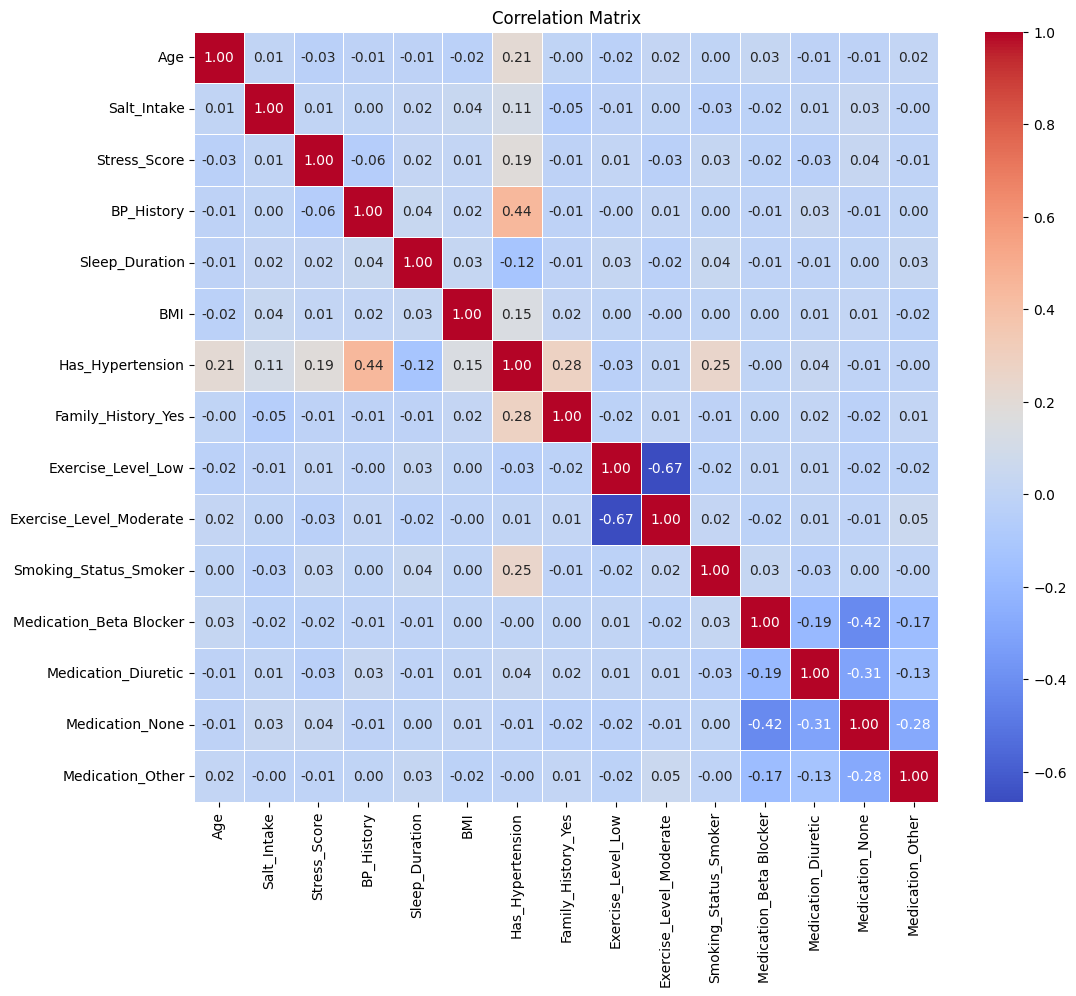

In [13]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [14]:
print("Correlation of Features with Has_Hypertension:")
print(correlation_matrix['Has_Hypertension'].sort_values(ascending=False))

Correlation of Features with Has_Hypertension:
Has_Hypertension           1.000000
BP_History                 0.441998
Family_History_Yes         0.282144
Smoking_Status_Smoker      0.251437
Age                        0.210677
Stress_Score               0.186910
BMI                        0.145093
Salt_Intake                0.114415
Medication_Diuretic        0.035637
Exercise_Level_Moderate    0.010509
Medication_Beta Blocker   -0.000494
Medication_Other          -0.003635
Medication_None           -0.006990
Exercise_Level_Low        -0.029544
Sleep_Duration            -0.119561
Name: Has_Hypertension, dtype: float64


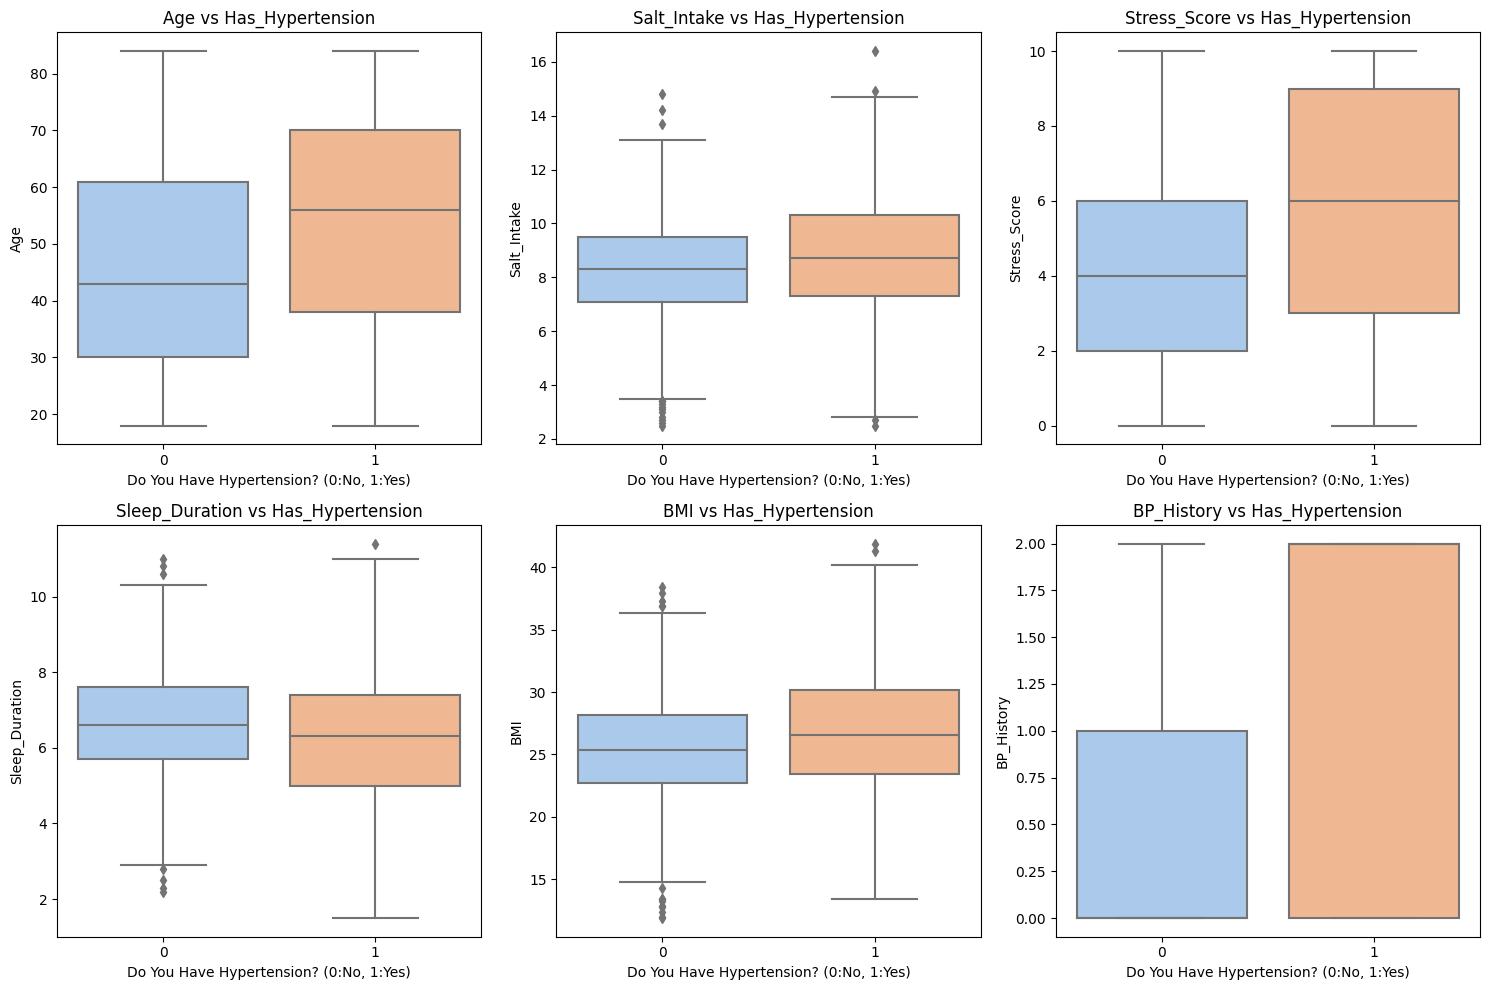

In [15]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Has_Hypertension', y=col, data=df, palette='pastel')
    plt.title(f'{col} vs Has_Hypertension')
    plt.xlabel('Do You Have Hypertension? (0:No, 1:Yes)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [16]:
X = df.drop('Has_Hypertension', axis=1)
y = df['Has_Hypertension'] 

print("Features (X) Dimension:", X.shape)
print("Target Variable (y) Dimension:", y.shape)

Features (X) Dimension: (1985, 14)
Target Variable (y) Dimension: (1985,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Training Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")

Training Set Size: 1588
Test Set Size: 397


In [18]:
numeric_cols_for_scaling = ['Age', 'Salt_Intake', 'Stress_Score', 'Sleep_Duration', 'BMI', 'BP_History']

scaler = StandardScaler()
X_train[numeric_cols_for_scaling] = scaler.fit_transform(X_train[numeric_cols_for_scaling])
X_test[numeric_cols_for_scaling] = scaler.transform(X_test[numeric_cols_for_scaling])

In [19]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'), 
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100), 
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') 
}

trained_models = {}

for name, model in models.items():
    print(f"[{name}] The model is being trained...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"[{name}] model training is completed.")

print("\nAll models were trained successfully.")

[Logistic Regression] The model is being trained...
[Logistic Regression] model training is completed.
[Random Forest] The model is being trained...
[Random Forest] model training is completed.
[XGBoost] The model is being trained...
[XGBoost] model training is completed.

All models were trained successfully.



--- Logistic Regression Evaluating the Model ---
Accuracy: 0.8212
F1 Score: 0.8264
ROC-AUC: 0.9185
Confusion Matrix:
 [[157  34]
 [ 37 169]]


<Figure size 600x500 with 0 Axes>

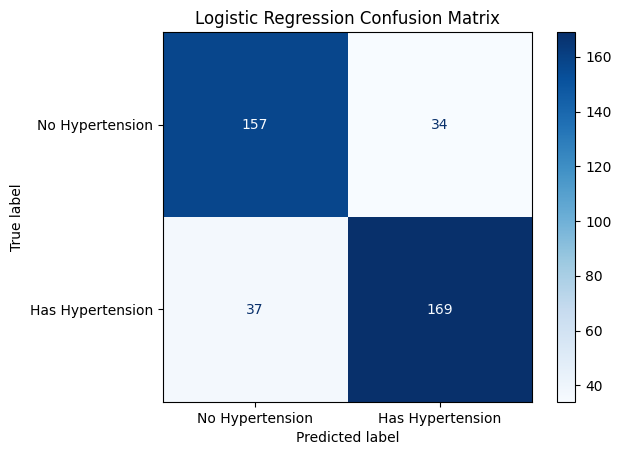


--- Random Forest Evaluating the Model ---
Accuracy: 0.9547
F1 Score: 0.9565
ROC-AUC: 0.9941
Confusion Matrix:
 [[181  10]
 [  8 198]]


<Figure size 600x500 with 0 Axes>

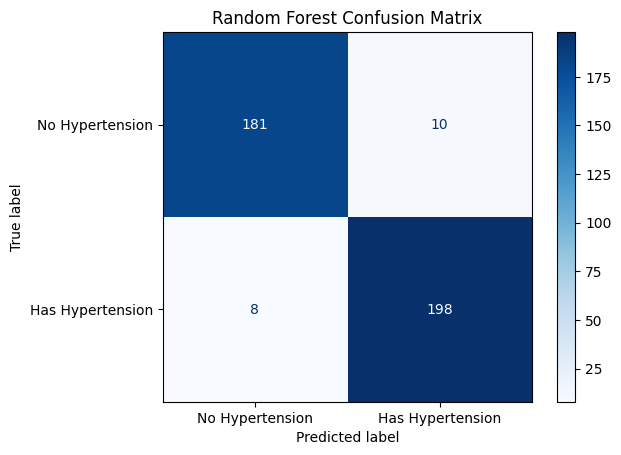


--- XGBoost Evaluating the Model ---
Accuracy: 0.9723
F1 Score: 0.9735
ROC-AUC: 0.9980
Confusion Matrix:
 [[184   7]
 [  4 202]]


<Figure size 600x500 with 0 Axes>

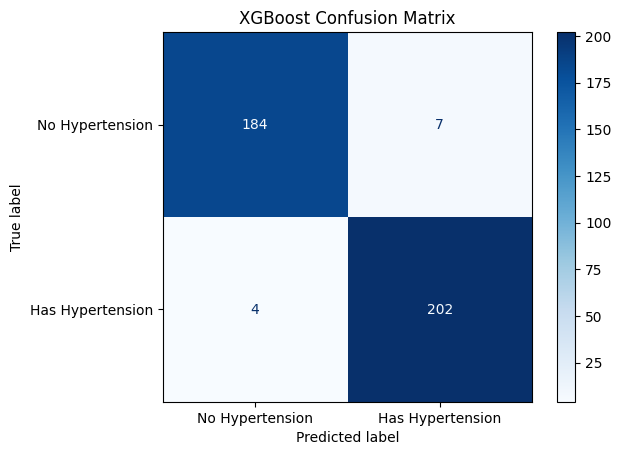

In [20]:
results = {}

for name, model in trained_models.items():
    print(f"\n--- {name} Evaluating the Model ---")

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] 

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Hypertension', 'Has Hypertension'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [21]:
print("Performance Summary of All Models:\n")
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")
    print(f"  ROC-AUC: {metrics['ROC-AUC']:.4f}")
    print("-" * 30)

Performance Summary of All Models:

Model: Logistic Regression
  Accuracy: 0.8212
  F1 Score: 0.8264
  ROC-AUC: 0.9185
------------------------------
Model: Random Forest
  Accuracy: 0.9547
  F1 Score: 0.9565
  ROC-AUC: 0.9941
------------------------------
Model: XGBoost
  Accuracy: 0.9723
  F1 Score: 0.9735
  ROC-AUC: 0.9980
------------------------------


In [22]:
best_model = trained_models['XGBoost']

feature_importances = best_model.feature_importances_ 

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Attribute Importances from XGBoost Model (Most Important to Least Important):")
print(importance_df)

Attribute Importances from XGBoost Model (Most Important to Least Important):
                    Feature  Importance
3                BP_History    0.358497
9     Smoking_Status_Smoker    0.121352
6        Family_History_Yes    0.103874
2              Stress_Score    0.102997
5                       BMI    0.070418
0                       Age    0.069109
1               Salt_Intake    0.067301
4            Sleep_Duration    0.065189
10  Medication_Beta Blocker    0.012512
13         Medication_Other    0.009282
8   Exercise_Level_Moderate    0.007685
7        Exercise_Level_Low    0.006250
12          Medication_None    0.005535
11      Medication_Diuretic    0.000000


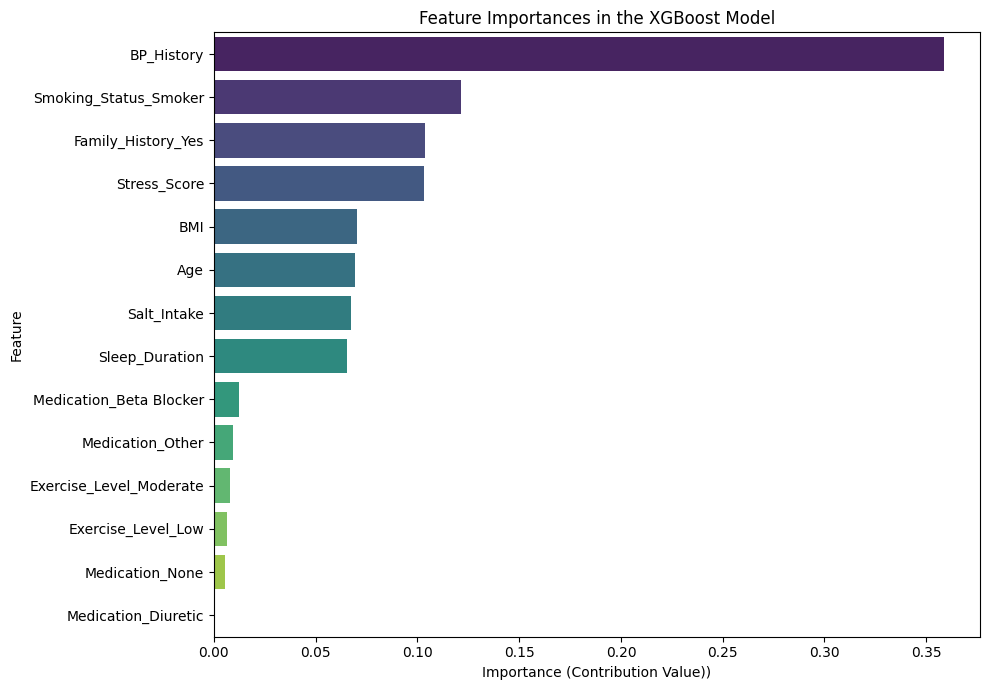

In [23]:
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances in the XGBoost Model')
plt.xlabel('Importance (Contribution Value))')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()